In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as R
%matplotlib inline
import matplotlib.pyplot as plt
from ahrs.filters import EKF, complementary
from numpy.random import default_rng


In [2]:
# Assuming a sampling rate of 1 sample per second
SAMPLING_RATE = 100
TOTAL_TIME = 360
STARTING_POSE = R.from_matrix(np.eye(3))    # Identity means no rotation, i.e. pointing north
ROTATIONAL_VELOCITY = np.array([0, 0, 0])    # this is the rotational velocity in rad/s of 1 rotation (2 pi) in the Z axis per hour (3600 seconds)

NORTH_VECTOR = np.array([1, 0, 0])     # 25 uT north
DOWN_VECTOR = np.array([0, 0, 1])       # 9.8 m/s/s down

GENERATED_NOISE_STD_DEV = [0.3, 0.5, 0.8]

EKF_NOISE = [0.3**2, 0.5**2, 0.8**2]

In [3]:
rotational_velocity_update_matrix = R.from_euler("XYZ", ROTATIONAL_VELOCITY / SAMPLING_RATE)

NUM_SAMPLES = TOTAL_TIME * SAMPLING_RATE

ideal_acc = np.zeros((NUM_SAMPLES, 3))
ideal_gyr = np.zeros((NUM_SAMPLES, 3))
ideal_mag = np.zeros((NUM_SAMPLES, 3))
ideal_pose = np.zeros((NUM_SAMPLES, 3))

current_pose = STARTING_POSE
for i in range(NUM_SAMPLES):
    current_pose = current_pose * rotational_velocity_update_matrix
    ideal_acc[i,:] = np.matmul(DOWN_VECTOR, current_pose.as_matrix())
    ideal_gyr[i,:] = ROTATIONAL_VELOCITY
    ideal_mag[i,:] = np.matmul(NORTH_VECTOR, current_pose.as_matrix())
    ideal_pose[i,:] = current_pose.as_euler('XYZ')
    
t = np.arange(0, TOTAL_TIME, 1 / SAMPLING_RATE)

rng = default_rng(seed=0)

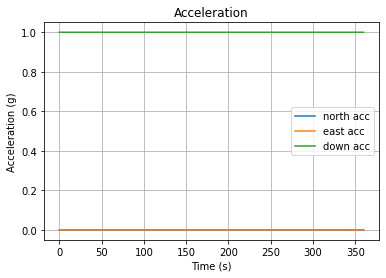

In [4]:
plt.plot(t, ideal_acc[:,0], label='north acc')
plt.plot(t, ideal_acc[:,1], label='east acc')
plt.plot(t, ideal_acc[:,2], label='down acc')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title("Acceleration")
plt.grid()

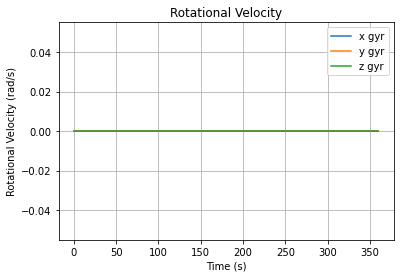

In [5]:
plt.plot(t, ideal_gyr[:,0], label='x gyr')
plt.plot(t, ideal_gyr[:,1], label='y gyr')
plt.plot(t, ideal_gyr[:,2], label='z gyr')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Rotational Velocity (rad/s)')
plt.title("Rotational Velocity")
plt.grid()

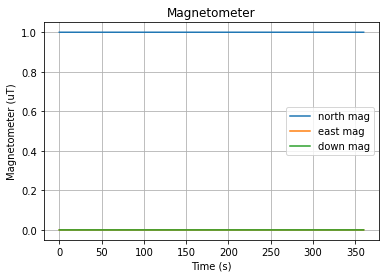

In [6]:
plt.plot(t, ideal_mag[:,0], label='north mag')
plt.plot(t, ideal_mag[:,1], label='east mag')
plt.plot(t, ideal_mag[:,2], label='down mag')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Magnetometer (uT)')
plt.title("Magnetometer")
plt.grid()

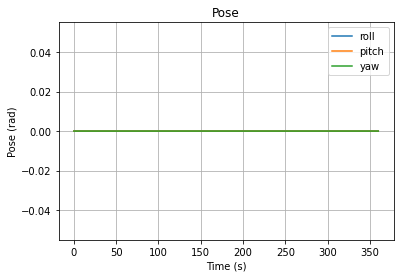

In [7]:
plt.plot(t, ideal_pose[:,0], label='roll')
plt.plot(t, ideal_pose[:,1], label='pitch')
plt.plot(t, ideal_pose[:,2], label='yaw')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Pose (rad)')
plt.title("Pose")
plt.grid()

In [8]:
# Insert noise
for i in range(NUM_SAMPLES):
    acc_noise = rng.normal(scale=GENERATED_NOISE_STD_DEV[0], size=3)
    gyr_noise = rng.normal(scale=GENERATED_NOISE_STD_DEV[1], size=3)
    mag_noise = rng.normal(scale=GENERATED_NOISE_STD_DEV[2], size=3)
    ideal_acc[i] += acc_noise
    ideal_gyr[i] += gyr_noise
    ideal_mag[i] += mag_noise

In [9]:
ekf = EKF(
# ekf = complementary.Complementary(
          frequency=SAMPLING_RATE,
          gyr=ideal_gyr,
          acc=ideal_acc,
          mag=ideal_mag,
        #   noise=EKF_NOISE,
          frame='NED'
          )

In [10]:
Q = ekf.Q

In [11]:
pose = np.zeros((NUM_SAMPLES, 3))
for i in range(NUM_SAMPLES):
    pose[i] = R.from_quat(Q[i]).as_euler('XYZ')

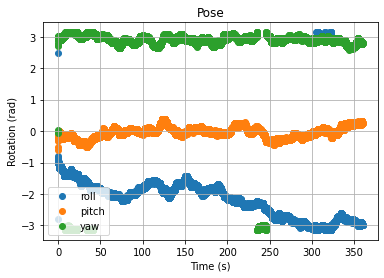

In [12]:
plt.scatter(t, pose[:,0], label='roll')
plt.scatter(t, pose[:,1], label='pitch')
plt.scatter(t, pose[:,2], label='yaw')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Rotation (rad)')
plt.title("Pose")
plt.grid()